# **Predicting Raw Material < 100 points**

## **Notebook Functionality**:




* Resample and use `skforecast` library to predict the raw materials with less than 100 points.
* Even though when reading the length of the data frames, it shows it has more points, it is because it has 0's in many rows. This is because their demand is intermittent, and spaced out. 

## **Inputs**:
* Raw Material ID #

# 1.0. Setup

In [39]:
! pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
# Importing required modules
import os
import math
import glob
import sklearn
import itertools
import statistics
import numpy as np 
import pandas as pd
import datetime as dt
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot
from sklearn.metrics import make_scorer
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import shapiro
from scipy.stats import kurtosis, skew
from IPython.core.interactiveshell import no_op
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster

sns.set()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2.0. Defining Functions

## 2.1. Data Processing Functions

In [36]:
def train_test_split(data, n_test):
	""" This function splits the dataset into train and test """
	return data[:-n_test], data[-n_test:]

In [37]:
def find_outliers_IQR(df):
  """ This function finds outliers and also returns the maximum value of the outlier upper bound """
  q1=df.quantile(0.25)
  q3=df.quantile(0.75)
  IQR=q3-q1
  outliers = df[(df>(q3+2*IQR))]
  max_val = float(q3+2*IQR)

  return outliers, max_val

## 2.2. XGBoost Functions

In [38]:
def season(mydate):
  """ This function creates seasons for the year, which will then be used as part of the creation of new features """
  
  # get the year from the date object
  year = mydate.year

  # create a list of seasons for comparison
  seasons = [
      (2, dt.date(year, 12, 21), dt.date(year, 12, 31)),
      (4, dt.date(year, 6, 21), dt.date(year, 9, 20)),
      (1, dt.date(year, 9, 21), dt.date(year, 12, 20)),
      (2, dt.date(year, 1, 1), dt.date(year, 3, 20)),
      (3, dt.date(year, 3, 21), dt.date(year, 6, 20)),
    ]

  # find the corresponding from the list and return it
  for season in seasons:
      if mydate >= season[1] and mydate <= season[2]:
          return season[0]

In [42]:
def clean_dataframe(df):
  """ This is a function to clean the dataframe that is not resampled """
  
  df = df.drop(columns = ['unidad','denominacion','denominacion_fleje','bobina_de_fabricacion','denominacion_bobina'])
  df.rename(columns = {'fecha':'ds','cantidad_de_acero_necesario_tm':'y'},inplace = True)
  df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
  df = df.set_index('ds')
  df = df.sort_index()
  df.reset_index(inplace = True)
  df = df[['ds','y']]
  df['ds'] = pd.to_datetime(df['ds'])

  return df

In [43]:
 def resample_df(df, resampling_param= 'W'): 
   """ This function is to resample the cleaned data frame """

   df = df.set_index('ds')
   df =  df.resample(resampling_param).sum()
   df = df.asfreq(resampling_param)
   df = df.sort_index()

   return df

In [44]:
def performance_forecast(forecast, df_test):
  """This function is to evaluate the performance metrics of the forecast"""

  metrics = {
      'MAE': [round(mean_absolute_error(df_test,forecast),2)],
      'MSE': [round(mean_squared_error(df_test, forecast),2)],
      'MAPE': [round(mean_absolute_percentage_error(df_test,forecast),2)],
      'WAPE': [round(abs((df_test - forecast).sum()) / (df_test).sum(),2)]
  }

  performance_metrics = pd.DataFrame(data=metrics)
  
  return performance_metrics

In [45]:
def get_holiday(date):
  """ This function is to create a to create a column indicating whether it was a holiday in spain or not"""

  spain_holidays = ['2015-12-31', '2016-12-31','2017-12-31', '2018-12-31', '2019-12-31',
                   '2020-12-31', '2021-12-31', '2022-12-31','2016-01-06', '2017-01-06',
                   '2018-01-06', '2019-01-06','2020-01-06', '2021-01-06', '2022-01-06', 
                   '2023-01-06','2020-04-09', '2021-04-01', '2022-04-14','2020-04-10', 
                   '2021-04-02', '2022-04-15','2015-05-01', '2016-05-01','2017-05-01',
                   '2018-05-01','2019-05-01','2020-05-01', '2021-05-01', '2022-05-01',
                   '2015-08-15','2017-08-15', '2018-08-15','2019-08-15','2020-08-15',
                   '2021-08-15', '2022-08-15','2015-10-12', '2016-10-12','2017-10-12',
                   '2018-10-12','2019-10-12','2020-10-12', '2021-10-12', '2022-10-12',
                   '2015-11-02', '2016-11-02','2017-11-02', '2018-11-02','2019-11-02',
                   '2020-11-02', '2021-11-02', '2022-11-02','2015-12-06', '2016-12-06',
                   '2017-12-06', '2018-12-06','2019-12-06''2020-12-06', '2021-12-06', 
                   '2022-12-06','2015-12-08', '2016-12-08','2017-12-08', '2018-12-08',
                    '2019-12-08,','2020-12-08', '2021-12-08', '2022-12-08','2015-12-24', 
                   '2016-12-24', '2017-12-24','2018-12-24', '2019-12-24', '2020-12-24', '2021-12-24', '2022-12-24']
  
  return np.where(date.isin(spain_holidays),1,0)

In [47]:
def create_features(df, label=None):
    """This function creates new exogeneous features for the model"""

    df['quarter'] = df['ds'].dt.quarter
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['dayofmonth'] = df['ds'].dt.day
    df['weekofyear'] = df['ds'].dt.weekofyear
    df['season'] = df['ds'].map(season)
    df['highseason'] = np.where(df['ds'].map(season) == 3, 1, 0) 
    df['holiday'] = get_holiday(df['ds'])
    df['y_log1p'] = np.log1p(df['y'].fillna(method='ffill'))
    

    return df

In [48]:
def my_scorer(y_true, y_pred):
  """ This function creates a scorer to calculate WAPE for the gridsearch when evaluating the performance of XGBoost """
  error = abs((y_true - y_pred)).sum() / (y_true).sum()
  return error

In [49]:
my_func = make_scorer(my_scorer)

In [50]:
def split_feat_predictors(df,label = 'y'):
  """ This function is to split the predictors vs. the predicted """

  X = df.loc[:, ~df.columns.isin(['y', 'y_log1p'])]

  y = df[label]
  return X, y

In [51]:
def timeseries_xgboost_skforecast(df,n_test= n_test):
  """This function is to get the predicted values with skforecast """
  
  (df.index == pd.date_range(
                    start = df.index.min(),
                    end   = df.index.max(),
                    freq  = df.index.freq)).all()

  print(f'Number of Missing Values: {df.isnull().any(axis=1).mean()}')

  data_train, data_test = train_test_split(df,n_test)

  #Treat outliers in the train set
  outliers, max_val = find_outliers_IQR(data_train['y'])
  data_train['anomaly'] = data_train["y"].isin(outliers)
  data_train.loc[data_train['anomaly'] == True,'y'] = np.nan
  data_train['y'] = data_train['y'].fillna(value=max_val)
  data_train.drop(columns='anomaly',inplace=True)

  X_train, y_train = split_feat_predictors(data_train,label = 'y')
  X_test, y_test = split_feat_predictors(data_test, label = 'y')  


  forecaster = ForecasterAutoreg(
              regressor = XGBRegressor(random_state=123),
              lags = 7
              )
  


    #Grid Search
  param_grid = {
  'n_estimators': [100, 500,1000,1500,2000],
  'max_depth': [3, 5, 10],
  'learning_rate': [0.01, 0.05,0.1],
  'colsample_bytree':[0.3,0.7]}



  steps = n_test
  lags_grid = [1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,26,52]

  results_grid = grid_search_forecaster(
      forecaster         = forecaster,
      y                  =  df['y'],
      exog               =  df.loc[:, ~df.columns.isin(['y', 'y_log1p'])],
      param_grid         = param_grid,
      lags_grid          = lags_grid,
      steps              = steps,
      refit              = True,
      metric             = my_scorer,
      initial_train_size = int(len(data_train)), # Model is trained with trainign data
      fixed_train_size   = False,
      return_best = True)
  

  metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = df['y'],
                            initial_train_size = len(y_train),
                            steps      = steps,
                            metric     = my_scorer,
                            verbose    = False
                        )
  

  fig, ax = plt.subplots(figsize=(11, 4))
  data_test['y'].plot(ax=ax, label='test')
  predictions['pred'].plot(ax=ax, label='predictions')
  ax.legend();

  print(f"Backtest error: {metric}")

  return predictions

Data frame has been resampled: two weeks
---------------------------------------------------------------------------
Successfully created dataframe for df_1004230 with shape (141, 11)
Count of zeros in column y is: 74
Count of zeros in column quarter is: 74
Count of zeros in column month is: 74
Count of zeros in column year is: 74
Count of zeros in column dayofyear is: 74
Count of zeros in column dayofmonth is: 74
Count of zeros in column weekofyear is: 74
Count of zeros in column season is: 74
Count of zeros in column highseason is: 123
Count of zeros in column holiday is: 141
Count of zeros in column y_log1p is: 74


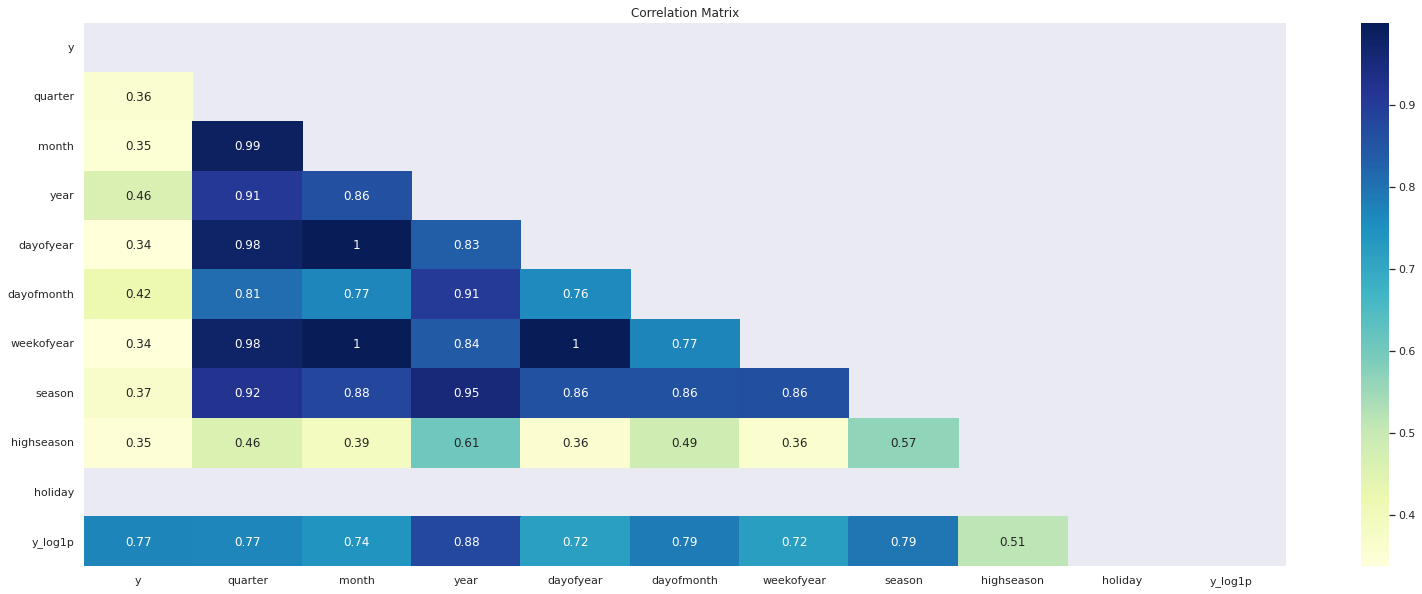

Dates train      : 2015-12-31 00:00:00 --- 2021-05-31 00:00:00  (n=131)
Dates test       : 2021-06-15 00:00:00 --- 2021-10-31 00:00:00  (n=10)
Count of zeros in column data train y is: 69
Count of zeros in column data train quarter is: 69
Count of zeros in column data train month is: 69
Count of zeros in column data train year is: 69
Count of zeros in column data train dayofyear is: 69
Count of zeros in column data train dayofmonth is: 69
Count of zeros in column data train weekofyear is: 69
Count of zeros in column data train season is: 69
Count of zeros in column data train highseason is: 113
Count of zeros in column data train holiday is: 131
Count of zeros in column data train y_log1p is: 69
Count of zeros in column data test y is: 5
Count of zeros in column data test quarter is: 5
Count of zeros in column data test month is: 5
Count of zeros in column data test year is: 5
Count of zeros in column data test dayofyear is: 5
Count of zeros in column data test dayofmonth is: 5
Count o

loop param_grid:   0%|                                             | 0/90 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/90 [00:00<00:22,  3.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:01<00:19,  4.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   8%|██▉                                  | 7/90 [00:01<00:12,  6.69it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:12,  6.56it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:14,  5.75it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:02<00:11,  6.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:12,  5.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:16,  4.70it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  17%|██████                              | 15/90 [00:03<00:20,  3.65it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:12,  5.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:09,  7.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:10,  6.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  30%|██████████▊                         | 27/90 [00:04<00:08,  7.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  32%|███████████▌                        | 29/90 [00:05<00:09,  6.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  33%|████████████                        | 30/90 [00:05<00:10,  5.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:05<00:07,  7.49it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:06<00:06,  8.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:06<00:06,  7.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:06<00:05,  8.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:07<00:06,  7.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:07<00:04,  9.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  54%|███████████████████▌                | 49/90 [00:07<00:05,  7.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:08<00:04,  7.75it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:08<00:05,  6.96it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:08<00:06,  5.61it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  63%|██████████████████████▊             | 57/90 [00:09<00:05,  5.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  64%|███████████████████████▏            | 58/90 [00:09<00:06,  4.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:09<00:08,  3.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:10<00:06,  4.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:10<00:05,  4.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:11<00:05,  4.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:11<00:03,  6.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:11<00:03,  6.12it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:11<00:03,  5.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:12<00:02,  6.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:12<00:02,  6.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:12<00:02,  5.70it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:13<00:01,  7.24it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:13<00:01,  6.54it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:13<00:01,  7.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:14<00:00,  6.96it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:14<00:00,  7.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:14<00:00,  7.65it/s]


Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:14<00:00,  6.69it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   2%|▊                                    | 2/90 [00:00<00:04, 20.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:09,  9.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   7%|██▍                                  | 6/90 [00:00<00:10,  8.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:00<00:10,  8.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:11,  6.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:01<00:11,  7.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  14%|█████▏                              | 13/90 [00:01<00:12,  6.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:15,  4.82it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:02<00:13,  5.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:12,  5.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  24%|████████▊                           | 22/90 [00:03<00:09,  7.44it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:03<00:09,  7.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:03<00:10,  6.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:04<00:08,  7.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:04<00:09,  6.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:04<00:10,  5.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:05<00:07,  7.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:05<00:08,  6.93it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:05<00:06,  8.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:05<00:06,  7.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:06<00:05,  8.70it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:06<00:06,  7.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:06<00:04,  8.98it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  54%|███████████████████▌                | 49/90 [00:07<00:05,  7.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:07<00:04,  7.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:07<00:05,  6.87it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:08<00:06,  5.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  63%|██████████████████████▊             | 57/90 [00:08<00:05,  5.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:01:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  64%|███████████████████████▏            | 58/90 [00:09<00:06,  4.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:09<00:08,  3.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:10<00:06,  4.41it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:10<00:05,  4.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:10<00:05,  4.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:11<00:03,  6.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:11<00:03,  6.08it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:11<00:03,  5.69it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:11<00:02,  6.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:12<00:02,  6.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:12<00:02,  5.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:12<00:01,  7.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:13<00:01,  6.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:13<00:01,  7.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:13<00:00,  7.65it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:13<00:00,  6.53it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:14<00:00,  7.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:14<00:00,  6.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   2%|▊                                    | 2/90 [00:00<00:05, 15.70it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:10,  7.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:10,  8.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:12,  6.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:01<00:11,  6.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:13,  5.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:17,  4.45it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:14,  5.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:13,  5.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  24%|████████▊                           | 22/90 [00:03<00:10,  6.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:11,  6.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:13,  4.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:04<00:10,  6.12it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:10,  5.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:05<00:11,  5.12it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:05<00:08,  6.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:08,  6.40it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:06<00:06,  7.82it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:06<00:07,  7.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:07<00:05,  8.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:07<00:06,  6.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:07<00:05,  8.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:07<00:05,  7.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:08<00:06,  6.44it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:08<00:05,  7.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:08<00:05,  6.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:09<00:07,  5.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  63%|██████████████████████▊             | 57/90 [00:09<00:06,  5.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  64%|███████████████████████▏            | 58/90 [00:10<00:07,  4.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:10<00:08,  3.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:11<00:06,  4.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:11<00:05,  4.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:11<00:05,  4.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:12<00:03,  5.92it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:12<00:03,  5.82it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:12<00:03,  5.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:12<00:02,  6.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:13<00:02,  6.03it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:13<00:02,  5.45it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:13<00:01,  6.93it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:14<00:01,  6.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:14<00:01,  7.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:14<00:00,  6.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:15<00:00,  7.82it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:15<00:00,  6.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   2%|▊                                    | 2/90 [00:00<00:04, 18.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:09,  8.69it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   7%|██▍                                  | 6/90 [00:00<00:10,  7.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:00<00:10,  7.87it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:12,  6.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:01<00:11,  6.84it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  14%|█████▏                              | 13/90 [00:01<00:12,  5.96it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:16,  4.65it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  17%|██████                              | 15/90 [00:02<00:21,  3.53it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:12,  5.67it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  24%|████████▊                           | 22/90 [00:03<00:09,  7.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:03<00:09,  6.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:03<00:11,  5.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:04<00:09,  6.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:04<00:10,  6.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:04<00:11,  5.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:05<00:08,  6.73it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:05<00:08,  6.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:05<00:06,  7.85it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:06<00:07,  6.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:06<00:05,  8.03it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:07<00:06,  6.84it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:07<00:05,  8.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:07<00:05,  7.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:07<00:06,  6.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:08<00:05,  6.86it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:08<00:06,  6.12it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:08<00:07,  4.88it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:09<00:09,  3.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:09<00:06,  4.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:09<00:07,  4.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:10<00:09,  3.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:10<00:06,  4.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:11<00:06,  4.47it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:11<00:05,  4.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:11<00:04,  5.61it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:12<00:03,  5.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:12<00:03,  5.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:12<00:02,  6.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:12<00:02,  6.03it/s]

[18:02:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:13<00:02,  5.46it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:13<00:01,  6.88it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:13<00:01,  6.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:13<00:01,  5.96it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:14<00:01,  7.17it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:14<00:00,  6.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:15<00:00,  7.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:15<00:00,  6.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   2%|▊                                    | 2/90 [00:00<00:04, 19.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:10,  8.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   7%|██▍                                  | 6/90 [00:00<00:11,  7.61it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:10,  7.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:13,  6.17it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:01<00:12,  6.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:14,  5.44it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:18,  4.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:14,  4.96it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:13,  5.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  24%|████████▊                           | 22/90 [00:03<00:10,  6.67it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:10,  6.42it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:11,  5.84it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:04<00:09,  6.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:04<00:09,  6.53it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:05<00:10,  5.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:05<00:07,  7.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:05<00:08,  6.75it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:06<00:06,  8.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:06<00:07,  7.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:06<00:05,  8.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:07<00:06,  7.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:07<00:04,  8.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:07<00:05,  7.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:07<00:06,  6.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:08<00:05,  6.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:08<00:06,  6.14it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:08<00:07,  4.85it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  63%|██████████████████████▊             | 57/90 [00:09<00:06,  5.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  64%|███████████████████████▏            | 58/90 [00:09<00:07,  4.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:10<00:09,  3.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:11<00:06,  4.17it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:11<00:06,  4.49it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:11<00:05,  4.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:11<00:04,  5.70it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:12<00:03,  5.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:12<00:03,  5.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:12<00:02,  6.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:12<00:02,  6.03it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:13<00:02,  5.47it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:13<00:01,  6.87it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:13<00:01,  6.47it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:13<00:01,  5.87it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:14<00:01,  7.18it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:14<00:00,  6.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00




loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:15<00:00,  7.69it/s]

[18:02:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:15<00:00,  6.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   2%|▊                                    | 2/90 [00:00<00:04, 18.84it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:10,  8.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:10,  8.13it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:11,  7.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:13,  5.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:01<00:12,  6.17it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:14,  5.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:18,  4.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:15,  4.85it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:13,  5.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  24%|████████▊                           | 22/90 [00:03<00:10,  6.67it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:10,  6.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:11,  5.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:04<00:09,  6.48it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:04<00:10,  6.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:05<00:11,  5.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:05<00:08,  7.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:05<00:08,  6.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:06<00:06,  7.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:06<00:07,  7.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:06<00:05,  8.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:07<00:06,  7.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:07<00:05,  8.48it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:07<00:05,  7.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:08<00:06,  6.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:08<00:05,  6.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:08<00:06,  5.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:09<00:08,  4.49it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:09<00:09,  3.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:09<00:06,  4.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:10<00:07,  4.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:10<00:09,  3.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:11<00:06,  4.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:11<00:06,  4.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:11<00:06,  4.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:12<00:04,  5.42it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:12<00:04,  5.41it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:12<00:04,  5.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:13<00:02,  6.05it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:13<00:02,  5.78it/s]

[18:03:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:13<00:03,  5.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:14<00:01,  6.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:14<00:01,  6.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:14<00:01,  5.69it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:14<00:01,  6.92it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:15<00:00,  6.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:15<00:00,  7.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:15<00:00,  6.46it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   2%|▊                                    | 2/90 [00:00<00:04, 19.40it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:10,  8.28it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:10,  7.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:11,  7.01it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:14,  5.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:01<00:12,  6.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:14,  5.18it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:19,  3.98it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:15,  4.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:13,  5.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  24%|████████▊                           | 22/90 [00:03<00:10,  6.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:10,  6.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:12,  5.42it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:04<00:10,  6.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:11,  5.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:05<00:13,  4.54it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:05<00:10,  5.61it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:09,  5.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:06<00:07,  7.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  42%|███████████████▏                    | 38/90 [00:06<00:07,  6.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▌                    | 39/90 [00:07<00:08,  5.98it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▊                   | 42/90 [00:07<00:07,  6.82it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  48%|█████████████████▏                  | 43/90 [00:07<00:07,  5.92it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  49%|█████████████████▌                  | 44/90 [00:08<00:08,  5.13it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  52%|██████████████████▊                 | 47/90 [00:08<00:06,  6.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:08<00:07,  5.96it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:08<00:07,  5.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:09<00:06,  5.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:09<00:07,  5.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:10<00:08,  4.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:10<00:10,  3.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:10<00:07,  4.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:11<00:07,  4.01it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:11<00:09,  3.17it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:12<00:07,  3.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:12<00:06,  4.24it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:12<00:06,  4.14it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:13<00:04,  5.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:13<00:04,  5.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:13<00:04,  4.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:14<00:03,  5.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:14<00:02,  5.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:14<00:03,  5.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:15<00:01,  6.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:15<00:01,  6.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:15<00:01,  5.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:15<00:01,  6.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:16<00:00,  6.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:16<00:00,  7.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:17<00:00,  6.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   2%|▊                                    | 2/90 [00:00<00:05, 17.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:10,  7.93it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:10,  7.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:12,  6.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:14,  5.47it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:01<00:13,  5.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:15,  4.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:20,  3.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:16,  4.49it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:14,  4.86it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:14,  4.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:10,  6.28it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:11,  5.92it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:12,  5.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:05<00:10,  5.85it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:11,  5.24it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:05<00:13,  4.44it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:06<00:10,  5.70it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  37%|█████████████▏                      | 33/90 [00:06<00:09,  5.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:10,  5.40it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▊                     | 37/90 [00:06<00:07,  6.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  42%|███████████████▏                    | 38/90 [00:07<00:08,  6.44it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▌                    | 39/90 [00:07<00:08,  5.92it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▊                   | 42/90 [00:07<00:07,  6.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  48%|█████████████████▏                  | 43/90 [00:08<00:07,  6.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  49%|█████████████████▌                  | 44/90 [00:08<00:08,  5.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  52%|██████████████████▊                 | 47/90 [00:08<00:06,  6.99it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:08<00:06,  6.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:09<00:07,  5.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:09<00:06,  6.17it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:09<00:06,  5.46it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:10<00:08,  4.43it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:10<00:10,  3.43it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:10<00:07,  4.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:11<00:07,  4.03it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:11<00:09,  3.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:12<00:07,  3.90it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:12<00:06,  4.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:12<00:06,  4.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:13<00:04,  5.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:13<00:04,  5.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:13<00:04,  4.97it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:14<00:03,  5.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:14<00:02,  5.70it/s]

[18:03:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:14<00:03,  5.18it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:15<00:01,  6.56it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:15<00:01,  6.28it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:15<00:01,  5.54it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:16<00:01,  6.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:16<00:00,  6.17it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:16<00:00,  7.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:17<00:00,  6.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   2%|▊                                    | 2/90 [00:00<00:05, 17.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:10,  8.02it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:10,  7.56it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:12,  6.73it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:14,  5.40it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:01<00:13,  5.73it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:15,  4.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:20,  3.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:16,  4.49it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:14,  4.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:14,  4.79it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:10,  6.24it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:11,  6.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:11,  5.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:05<00:09,  6.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:10,  6.06it/s]

[18:03:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:05<00:11,  5.51it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:05<00:08,  7.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:08,  6.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:06<00:06,  7.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:06<00:07,  6.79it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:07<00:06,  7.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:07<00:06,  6.82it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:07<00:05,  8.08it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:08<00:05,  7.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:08<00:06,  5.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:08<00:06,  6.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:09<00:06,  5.44it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:09<00:08,  4.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:10<00:10,  3.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:10<00:07,  4.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:10<00:08,  3.88it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:11<00:10,  3.03it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:12<00:08,  3.40it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:12<00:07,  3.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:12<00:07,  3.70it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:13<00:04,  4.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:13<00:04,  4.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:13<00:04,  4.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:14<00:03,  5.70it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:14<00:03,  5.53it/s]


----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:14<00:03,  5.01it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:14<00:02,  6.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:15<00:01,  6.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:15<00:02,  5.46it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:15<00:01,  6.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:03:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:16<00:00,  6.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:16<00:00,  7.14it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:16<00:00,  6.88it/s]


Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:16<00:00,  6.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   2%|▊                                    | 2/90 [00:00<00:05, 15.96it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:11,  7.70it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:10,  7.93it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:11,  6.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:14,  5.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:01<00:13,  5.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:15,  4.87it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:20,  3.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:16,  4.44it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:15,  4.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:14,  4.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:10,  6.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:10,  6.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:12,  5.49it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:05<00:09,  6.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:10,  6.10it/s]

[18:04:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:05<00:11,  5.49it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:05<00:08,  7.05it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:08,  6.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:06<00:07,  7.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:06<00:07,  6.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:07<00:06,  7.79it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:07<00:06,  6.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:08<00:05,  7.97it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:08<00:05,  7.05it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:08<00:07,  5.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:09<00:06,  6.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:09<00:06,  5.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:09<00:08,  4.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:10<00:10,  3.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:10<00:07,  4.42it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:10<00:08,  3.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:11<00:10,  3.01it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:12<00:07,  3.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:12<00:06,  4.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:12<00:06,  3.90it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:13<00:04,  5.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:13<00:04,  5.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:13<00:04,  4.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:14<00:03,  5.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:14<00:03,  5.47it/s]

[18:04:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:14<00:03,  4.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:14<00:02,  6.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:15<00:02,  5.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:15<00:02,  5.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:15<00:01,  6.54it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:16<00:00,  6.05it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:16<00:00,  7.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:16<00:00,  6.82it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:16<00:00,  6.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   2%|▊                                    | 2/90 [00:00<00:05, 16.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:11,  7.48it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:10,  7.69it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:12,  6.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:15,  5.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:02<00:13,  5.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:19,  3.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:23,  3.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:19,  3.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:17,  4.17it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 19/90 [00:04<00:16,  4.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:11,  5.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:11,  5.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:05<00:11,  5.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:05<00:09,  6.48it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:09,  6.24it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:05<00:10,  5.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:06<00:08,  7.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:08,  6.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▊                     | 37/90 [00:06<00:07,  7.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:07<00:07,  6.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:07<00:06,  7.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:08<00:06,  6.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:08<00:05,  8.13it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:08<00:05,  7.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:08<00:07,  5.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:09<00:06,  6.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:09<00:06,  5.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:10<00:08,  4.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:10<00:10,  3.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:10<00:07,  4.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:11<00:08,  3.79it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:11<00:10,  2.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:12<00:07,  3.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:12<00:06,  3.90it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:13<00:06,  3.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:13<00:04,  4.87it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:13<00:04,  4.92it/s]

[18:04:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:14<00:04,  4.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████        | 70/90 [00:14<00:04,  4.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:14<00:03,  5.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:14<00:03,  5.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:15<00:03,  4.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:15<00:02,  6.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:15<00:02,  5.85it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:15<00:02,  5.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:16<00:01,  6.46it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:16<00:01,  5.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:17<00:00,  6.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:17<00:00,  6.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:17<00:00,  5.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   2%|▊                                    | 2/90 [00:00<00:05, 15.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:12,  7.13it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:11,  7.48it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:12,  6.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:15,  5.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:02<00:14,  5.51it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:16,  4.61it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:21,  3.53it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:17,  4.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:15,  4.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:15,  4.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:11,  6.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:11,  5.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:11,  5.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:05<00:09,  6.48it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:10,  6.12it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:05<00:10,  5.56it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:06<00:08,  7.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:09,  6.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:06<00:07,  7.46it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:07<00:07,  6.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:07<00:06,  7.86it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:07<00:06,  6.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:08<00:05,  8.12it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:08<00:05,  7.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:08<00:07,  5.73it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:09<00:06,  6.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:09<00:07,  5.28it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:09<00:08,  4.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:10<00:11,  3.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:10<00:07,  4.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:11<00:08,  3.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:11<00:10,  2.93it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:12<00:07,  3.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:12<00:06,  3.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:12<00:06,  3.82it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:13<00:04,  4.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:13<00:04,  4.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:13<00:04,  4.69it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████        | 70/90 [00:14<00:04,  4.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:14<00:03,  5.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:14<00:03,  5.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:14<00:03,  4.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:15<00:02,  6.05it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:15<00:02,  5.88it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:15<00:02,  5.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:16<00:01,  6.43it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:16<00:01,  6.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:16<00:01,  5.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:16<00:00,  6.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:17<00:00,  6.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:17<00:00,  5.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   2%|▊                                    | 2/90 [00:00<00:05, 16.08it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:11,  7.65it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:10,  7.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:12,  6.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:15,  5.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:02<00:14,  5.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:16,  4.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:21,  3.53it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:17,  4.28it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:15,  4.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:15,  4.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:11,  6.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:11,  5.92it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:11,  5.53it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:05<00:09,  6.46it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:10,  6.12it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:05<00:10,  5.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:06<00:08,  7.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:04:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:08,  6.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:06<00:06,  7.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:07<00:07,  6.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:07<00:06,  7.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:07<00:06,  6.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:08<00:05,  7.96it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:08<00:05,  7.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:08<00:07,  5.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:09<00:06,  5.88it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:09<00:07,  5.14it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:09<00:09,  3.99it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:10<00:11,  3.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:10<00:07,  4.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:11<00:08,  3.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:11<00:10,  2.85it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:12<00:07,  3.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:12<00:07,  3.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:12<00:07,  3.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:13<00:04,  4.86it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:13<00:04,  4.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:13<00:04,  4.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████        | 70/90 [00:14<00:04,  4.22it/s]


Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror

loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:14<00:03,  5.56it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:14<00:03,  5.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:14<00:03,  4.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:15<00:02,  6.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:15<00:02,  5.92it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:15<00:02,  5.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:16<00:01,  6.42it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:16<00:01,  6.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:16<00:01,  5.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:17<00:00,  6.82it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:17<00:00,  6.65it/s]


Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:17<00:00,  6.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   2%|▊                                    | 2/90 [00:00<00:05, 16.43it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:11,  7.67it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:11,  7.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:12,  6.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:16,  5.02it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:02<00:14,  5.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:17,  4.47it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:22,  3.43it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:17,  4.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:15,  4.61it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:15,  4.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:11,  6.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:11,  5.93it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:11,  5.53it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:05<00:09,  6.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:10,  6.01it/s]

[18:05:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:05<00:11,  5.45it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:06<00:08,  6.90it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:08,  6.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:06<00:06,  7.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:07<00:07,  6.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:07<00:06,  7.75it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:07<00:06,  6.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:08<00:05,  7.75it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:08<00:06,  6.85it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:08<00:07,  5.44it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:09<00:06,  5.69it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:09<00:07,  4.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:10<00:09,  3.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:10<00:11,  2.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:10<00:08,  4.05it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:11<00:09,  3.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:11<00:11,  2.79it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:12<00:07,  3.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:12<00:07,  3.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:13<00:07,  3.65it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:13<00:04,  4.84it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:13<00:04,  4.88it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:14<00:04,  4.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████        | 70/90 [00:14<00:04,  4.14it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:14<00:03,  5.40it/s]


Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:14<00:03,  5.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:15<00:03,  4.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:15<00:02,  6.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:15<00:02,  5.90it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:16<00:02,  5.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:16<00:01,  6.53it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:16<00:01,  6.44it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:16<00:01,  5.86it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:17<00:00,  6.69it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:17<00:00,  6.43it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:17<00:00,  5.79it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   2%|▊                                    | 2/90 [00:00<00:05, 14.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:11,  7.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:11,  7.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:12,  6.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:16,  4.97it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:02<00:14,  5.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:17,  4.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:22,  3.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:17,  4.14it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:16,  4.48it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 19/90 [00:04<00:16,  4.41it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:11,  5.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:11,  5.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:12,  5.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:05<00:09,  6.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:10,  6.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:05<00:11,  5.48it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:06<00:08,  6.90it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:09,  6.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:06<00:07,  7.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:07<00:07,  6.47it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:07<00:06,  7.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:08<00:06,  6.70it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:08<00:05,  7.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:08<00:06,  6.67it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:08<00:07,  5.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:09<00:06,  5.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:09<00:07,  4.88it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:10<00:09,  3.86it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:10<00:11,  2.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:11<00:08,  4.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:11<00:09,  3.53it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:12<00:11,  2.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:12<00:07,  3.51it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:13<00:07,  3.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:13<00:07,  3.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:13<00:04,  4.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:14<00:04,  4.79it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:14<00:04,  4.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████        | 70/90 [00:14<00:04,  4.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:14<00:03,  5.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:15<00:03,  5.24it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:15<00:03,  4.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:15<00:02,  6.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:16<00:02,  5.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:16<00:02,  5.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:16<00:01,  6.46it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:17<00:01,  5.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:17<00:00,  6.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:17<00:00,  6.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:17<00:00,  5.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   2%|▊                                    | 2/90 [00:00<00:05, 15.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:11,  7.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:11,  7.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:12,  6.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:16,  4.97it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████                                | 10/90 [00:01<00:20,  3.82it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  13%|████▊                               | 12/90 [00:02<00:15,  5.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:17,  4.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:03<00:22,  3.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:17,  4.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:16,  4.45it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 19/90 [00:04<00:16,  4.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:11,  5.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:11,  5.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:12,  5.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:05<00:10,  6.28it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:10,  5.99it/s]

[18:05:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:05<00:11,  5.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:06<00:08,  6.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:09,  6.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:07<00:07,  7.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:07<00:07,  6.51it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:07<00:06,  7.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:08<00:07,  6.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:08<00:05,  7.53it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:08<00:06,  6.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:09<00:07,  5.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:09<00:06,  5.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:09<00:07,  4.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:10<00:09,  3.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:10<00:12,  2.88it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:11<00:08,  3.96it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:11<00:09,  3.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:05:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:12<00:11,  2.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:12<00:07,  3.53it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:13<00:07,  3.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:13<00:07,  3.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:14<00:04,  4.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:14<00:04,  4.73it/s]

[18:06:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:14<00:04,  4.46it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████        | 70/90 [00:14<00:04,  4.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:15<00:03,  5.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:15<00:03,  5.14it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:15<00:03,  4.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:15<00:02,  5.92it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:16<00:02,  5.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:16<00:02,  5.24it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:16<00:01,  6.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:17<00:01,  6.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:17<00:01,  5.75it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:17<00:00,  6.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:17<00:00,  6.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:18<00:00,  5.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   2%|▊                                    | 2/90 [00:00<00:05, 15.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:12,  7.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:11,  7.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:12,  6.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:16,  4.97it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████                                | 10/90 [00:01<00:20,  3.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  13%|████▊                               | 12/90 [00:02<00:15,  5.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:17,  4.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:03<00:22,  3.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:17,  4.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:16,  4.40it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 19/90 [00:04<00:16,  4.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:11,  5.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:11,  5.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:05<00:12,  5.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:05<00:10,  6.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:10,  5.87it/s]

[18:06:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:05<00:11,  5.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:06<00:08,  6.75it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:09,  6.02it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▊                     | 37/90 [00:07<00:07,  7.28it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:07<00:08,  6.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:07<00:06,  7.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:08<00:07,  6.48it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:08<00:05,  7.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:08<00:06,  6.61it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:09<00:07,  5.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  56%|████████████████████                | 50/90 [00:09<00:09,  4.08it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  58%|████████████████████▊               | 52/90 [00:09<00:07,  5.42it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▏              | 53/90 [00:10<00:07,  4.73it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:10<00:09,  3.67it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:11<00:12,  2.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:11<00:08,  3.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:11<00:09,  3.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:12<00:11,  2.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:13<00:08,  3.40it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:13<00:07,  3.61it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:13<00:07,  3.49it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:14<00:04,  4.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:14<00:04,  4.61it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:14<00:04,  4.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████        | 70/90 [00:15<00:05,  3.99it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:15<00:03,  5.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:15<00:03,  5.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:15<00:03,  4.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:16<00:02,  5.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:16<00:02,  5.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:16<00:02,  5.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:17<00:01,  6.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:17<00:01,  6.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:17<00:01,  5.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:18<00:00,  6.53it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:18<00:00,  6.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:18<00:00,  5.61it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   2%|▊                                    | 2/90 [00:00<00:05, 14.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:12,  6.85it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|██▉                                  | 7/90 [00:01<00:11,  6.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:13,  5.98it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:17,  4.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████                                | 10/90 [00:02<00:21,  3.65it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  13%|████▊                               | 12/90 [00:02<00:15,  4.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:18,  4.14it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:03<00:23,  3.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:18,  4.02it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  20%|███████▏                            | 18/90 [00:04<00:16,  4.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 19/90 [00:04<00:16,  4.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:12,  5.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:12,  5.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:05<00:12,  5.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:05<00:10,  6.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:10,  5.86it/s]

[18:06:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:06<00:11,  5.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:06<00:08,  6.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:09,  6.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:07<00:07,  7.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:07<00:07,  6.54it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:07<00:06,  7.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:08<00:07,  6.44it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:08<00:05,  7.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:08<00:06,  6.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:09<00:07,  5.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  56%|████████████████████                | 50/90 [00:09<00:10,  4.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  58%|████████████████████▊               | 52/90 [00:09<00:07,  5.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▏              | 53/90 [00:10<00:08,  4.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:10<00:09,  3.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:11<00:12,  2.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:11<00:08,  3.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:11<00:09,  3.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:12<00:11,  2.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:13<00:08,  3.40it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:13<00:07,  3.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:13<00:07,  3.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:14<00:05,  4.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:14<00:04,  4.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:14<00:04,  4.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████        | 70/90 [00:15<00:05,  3.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:15<00:03,  5.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:15<00:03,  4.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:16<00:03,  4.49it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:16<00:02,  5.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:16<00:02,  5.47it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:16<00:02,  5.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:17<00:01,  6.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:17<00:01,  6.02it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:17<00:01,  5.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:18<00:00,  6.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:18<00:00,  6.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:18<00:00,  5.53it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   2%|▊                                    | 2/90 [00:00<00:06, 14.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:12,  6.97it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|██▉                                  | 7/90 [00:01<00:11,  6.98it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:13,  6.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:16,  4.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████                                | 10/90 [00:02<00:21,  3.69it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  13%|████▊                               | 12/90 [00:02<00:15,  5.01it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:18,  4.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:03<00:23,  3.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:18,  4.03it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  20%|███████▏                            | 18/90 [00:04<00:16,  4.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 19/90 [00:04<00:16,  4.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:12,  5.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:11,  5.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:05<00:12,  5.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:05<00:10,  6.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:10,  5.84it/s]

[18:06:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:06<00:11,  5.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:06<00:08,  6.61it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:09,  6.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:07<00:07,  7.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:07<00:08,  6.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:07<00:06,  7.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:08<00:07,  6.42it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:08<00:05,  7.43it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:08<00:06,  6.41it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:09<00:08,  5.05it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|████████████████████▊               | 52/90 [00:09<00:07,  5.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:10<00:07,  4.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:10<00:09,  3.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:11<00:12,  2.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:11<00:08,  3.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:11<00:09,  3.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:12<00:11,  2.65it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:13<00:08,  3.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:13<00:07,  3.54it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:13<00:07,  3.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|██████████████████████████          | 65/90 [00:14<00:07,  3.30it/s]


Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror

loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:14<00:04,  4.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:14<00:04,  4.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:14<00:04,  4.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████        | 70/90 [00:15<00:05,  3.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:15<00:03,  5.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:15<00:03,  4.96it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:06:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:16<00:03,  4.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:16<00:02,  5.70it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:16<00:02,  5.61it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:16<00:02,  5.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:17<00:01,  6.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:17<00:01,  6.05it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:17<00:01,  5.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:18<00:00,  6.43it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:18<00:00,  6.18it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:18<00:00,  5.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   2%|▊                                    | 2/90 [00:00<00:05, 14.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:12,  6.87it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|██▉                                  | 7/90 [00:01<00:11,  6.98it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:13,  6.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:16,  4.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████                                | 10/90 [00:02<00:21,  3.69it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  13%|████▊                               | 12/90 [00:02<00:15,  5.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:18,  4.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:03<00:23,  3.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:17,  4.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:16,  4.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 19/90 [00:04<00:16,  4.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:12,  5.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:11,  5.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:05<00:12,  5.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:05<00:10,  6.18it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:10,  5.90it/s]

[18:07:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:06<00:11,  5.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:06<00:08,  6.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:09,  6.17it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  41%|██████████████▊                     | 37/90 [00:07<00:07,  7.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:07<00:07,  6.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:07<00:06,  7.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:08<00:07,  6.28it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:08<00:05,  7.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:08<00:06,  6.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:09<00:08,  5.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  56%|████████████████████                | 50/90 [00:09<00:10,  3.88it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  58%|████████████████████▊               | 52/90 [00:09<00:07,  5.17it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▏              | 53/90 [00:10<00:08,  4.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:10<00:10,  3.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:11<00:13,  2.67it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:11<00:08,  3.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:12<00:09,  3.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:12<00:11,  2.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:13<00:08,  3.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:13<00:07,  3.46it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:14<00:07,  3.43it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:14<00:04,  4.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:14<00:04,  4.63it/s]

[18:07:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:15<00:04,  4.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████        | 70/90 [00:15<00:04,  4.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:15<00:03,  5.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:15<00:03,  5.03it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:16<00:03,  4.54it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:16<00:02,  5.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:16<00:02,  5.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:17<00:02,  5.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:17<00:01,  6.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:17<00:01,  6.17it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:17<00:01,  5.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:18<00:00,  6.40it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:18<00:00,  6.13it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:18<00:00,  5.44it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   2%|▊                                    | 2/90 [00:00<00:05, 14.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:12,  6.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|██▉                                  | 7/90 [00:01<00:12,  6.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:14,  5.73it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:17,  4.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████                                | 10/90 [00:02<00:22,  3.49it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  13%|████▊                               | 12/90 [00:02<00:16,  4.79it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:18,  4.08it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:03<00:23,  3.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:03<00:18,  4.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  20%|███████▏                            | 18/90 [00:04<00:16,  4.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 19/90 [00:04<00:16,  4.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:12,  5.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:04<00:12,  5.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:05<00:12,  5.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:05<00:10,  6.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:05<00:10,  5.85it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:06<00:11,  5.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:06<00:08,  6.56it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  37%|█████████████▏                      | 33/90 [00:06<00:08,  6.56it/s]


Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  38%|█████████████▌                      | 34/90 [00:06<00:09,  6.02it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▊                     | 37/90 [00:07<00:07,  7.28it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  43%|███████████████▌                    | 39/90 [00:07<00:07,  6.46it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  47%|████████████████▊                   | 42/90 [00:08<00:06,  7.42it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:08<00:07,  6.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  52%|██████████████████▊                 | 47/90 [00:08<00:06,  6.98it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:09<00:06,  6.02it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:09<00:08,  4.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  56%|████████████████████                | 50/90 [00:09<00:10,  3.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  58%|████████████████████▊               | 52/90 [00:10<00:07,  4.87it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▏              | 53/90 [00:10<00:08,  4.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:10<00:10,  3.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:11<00:13,  2.54it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:11<00:09,  3.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:12<00:10,  3.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:12<00:12,  2.47it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:13<00:08,  3.12it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:14<00:08,  3.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:14<00:07,  3.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|██████████████████████████          | 65/90 [00:14<00:08,  3.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:15<00:05,  4.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:15<00:05,  4.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:15<00:05,  4.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████        | 70/90 [00:15<00:05,  3.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:16<00:03,  4.88it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:16<00:03,  4.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:16<00:03,  4.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:17<00:02,  5.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:17<00:02,  5.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:17<00:02,  4.86it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:18<00:01,  5.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:18<00:01,  5.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:18<00:01,  5.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:19<00:00,  6.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:19<00:00,  5.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:19<00:00,  5.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   2%|▊                                    | 2/90 [00:00<00:06, 12.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:15,  5.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|██▉                                  | 7/90 [00:01<00:14,  5.79it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:16,  5.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:20,  3.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  13%|████▊                               | 12/90 [00:02<00:17,  4.43it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:19,  4.01it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:03<00:22,  3.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  19%|██████▊                             | 17/90 [00:04<00:17,  4.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  20%|███████▏                            | 18/90 [00:04<00:16,  4.43it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 19/90 [00:04<00:16,  4.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▊                           | 22/90 [00:04<00:11,  5.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  26%|█████████▏                          | 23/90 [00:05<00:11,  5.65it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  27%|█████████▌                          | 24/90 [00:05<00:12,  5.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▊                         | 27/90 [00:05<00:10,  6.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  31%|███████████▏                        | 28/90 [00:06<00:10,  5.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:06<00:11,  5.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|████████████▊                       | 32/90 [00:06<00:08,  6.54it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  37%|█████████████▏                      | 33/90 [00:06<00:08,  6.49it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  38%|█████████████▌                      | 34/90 [00:07<00:09,  5.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▊                     | 37/90 [00:07<00:07,  7.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  42%|███████████████▏                    | 38/90 [00:07<00:07,  6.93it/s]


Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▌                    | 39/90 [00:07<00:08,  6.24it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▊                   | 42/90 [00:08<00:06,  6.98it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  48%|█████████████████▏                  | 43/90 [00:08<00:07,  6.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  49%|█████████████████▌                  | 44/90 [00:08<00:07,  6.02it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  52%|██████████████████▊                 | 47/90 [00:09<00:06,  6.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  53%|███████████████████▏                | 48/90 [00:09<00:07,  5.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 49/90 [00:09<00:10,  4.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  56%|████████████████████                | 50/90 [00:10<00:13,  3.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  58%|████████████████████▊               | 52/90 [00:10<00:09,  4.13it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▏              | 53/90 [00:11<00:10,  3.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▌              | 54/90 [00:11<00:12,  2.84it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████              | 55/90 [00:12<00:15,  2.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:12<00:10,  3.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|███████████████████████▏            | 58/90 [00:13<00:11,  2.86it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:13<00:13,  2.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  69%|████████████████████████▊           | 62/90 [00:14<00:09,  2.99it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:14<00:08,  3.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:15<00:08,  3.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|██████████████████████████          | 65/90 [00:15<00:08,  3.08it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:15<00:05,  4.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:16<00:05,  4.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:16<00:05,  3.90it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████        | 70/90 [00:16<00:05,  3.48it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:17<00:03,  4.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:17<00:03,  4.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:17<00:03,  4.01it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:07:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:18<00:02,  4.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:08:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:08:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:18<00:02,  4.95it/s]

[18:08:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:08:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:18<00:02,  4.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:08:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:19<00:01,  5.46it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:08:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:08:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:19<00:01,  5.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:08:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:19<00:01,  4.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:08:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:20<00:00,  5.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:08:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:08:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:20<00:00,  5.41it/s]

[18:08:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:08:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:20<00:00,  4.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 131
Number of observations used for backtesting: 10
    Number of folds: 1
    Number of steps per fold: 10

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2021-05-31 00:00:00
    Validation: 2021-06-15 00:00:00 -- 2021-10-31 00:00:00

[18:08:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid: 100%|█████████████████████████████████████| 22/22 [06:26<00:00, 17.58s/it]


[18:08:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52] 
  Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 2000}
  Backtesting metric: 0.6845179594647308

[18:08:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:08:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Backtest error: 1.6996877836598054


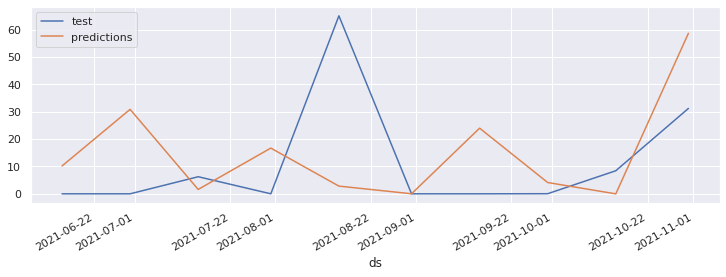

In [24]:
# specifying the path to csv files
path = ""
  
# csv files in the path
#files = glob.glob(path + "/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/*.csv")
files = glob.glob(path + "/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Bobinas csv no resample/bob/other/bob1/*.csv")


  
# defining an empty list to store dataframes of each bobina
data_frames = []
bobinas = []
  
# checking all the csv files in the specified path
for filename in files:

    temp_df = pd.read_csv(filename, index_col=None)
    #temp_df = temp_df.drop(columns = 'Unnamed: 0')
    #temp_df.index = pd.to_datetime(temp_df.index)
    bobina_name = 'df_' + str(filename[-11:-4])
    bobinas.append(bobina_name)

    temp_df = clean_dataframe(temp_df)
    temp_df = create_features(temp_df)
    
    resample_param = 'SM'
    temp_df = resample_df(temp_df,resample_param)

    if resample_param == 'W':
      n_test = 20
      resampled = 'weekly'
    elif resample_param == 'M':
      n_test = 5
      resampled = 'monthly'
    elif resample_param  == 'SM':
      n_test = 10
      resampled = 'two weeks'
    elif resample_param == 'BM':
      n_test = 20
      resampled = 'business monthly'
    elif resample_param == 'D':
      n_test = 150
      resampled = 'daily'

    else:
      pass

    print(f'Data frame has been resampled: {resampled}')




    globals()[str(bobina_name)] = pd.DataFrame(temp_df)

    
    data_frames.append(temp_df)
    print("---------------------------------------------------------------------------")
    print(f'Successfully created dataframe for {bobina_name} with shape {temp_df.shape}')





    # Count number of zeros in all columns 
    for column_name in temp_df.columns:
      column = temp_df[column_name]
      count = (column == 0).sum()
      print('Count of zeros in column', column_name, 'is:', count)
    
    plt.figure(figsize = (24,10))
    matrix = np.triu(temp_df.corr())
    sns.heatmap(temp_df.corr(), annot = True, cmap="YlGnBu", mask=matrix)
    plt.title("Correlation Matrix")
    plt.show()

 

    data_train, data_test = train_test_split(temp_df,n_test)

    print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
    print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})") 


        # Count number of zeros in all columns 
    for column_name in data_train.columns:
      column = data_train[column_name]
      count = (column == 0).sum()
      print('Count of zeros in column data train', column_name, 'is:', count)

    
            # Count number of zeros in all columns 
    for column_name in data_test.columns:
      column = data_test[column_name]
      count = (column == 0).sum()
      print('Count of zeros in column data test', column_name, 'is:', count)

    skforecast_predictions_xgb = timeseries_xgboost_skforecast(temp_df,n_test)
    metrics_skforecast_xgb =performance_forecast(skforecast_predictions_xgb['pred'],data_test['y'])
    metrics_skforecast_xgb_name = 'metrics_skforecast_xgb_' + str(filename[-11:-4])
    globals()[str(metrics_skforecast_xgb_name)] = pd.DataFrame(metrics_skforecast_xgb)



In [25]:
 metrics_skforecast_xgb_1004230

,MAE,MSE,MAPE,WAPE
0,18.86,664.92,3.682026e+16,0.34


In [29]:
print(f"Total tons predicted (5 months): {sum(skforecast_predictions_xgb['pred'])}")
print(f"Total tons test: {sum(data_test['y'].tail(10))}")

Total tons predicted (5 months): 148.944433927536
Total tons test: 110.982


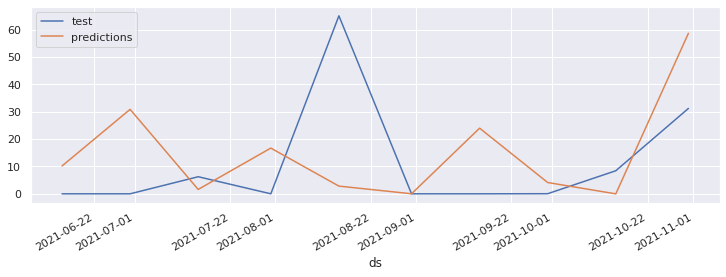

In [54]:
fig, ax = plt.subplots(figsize=(11, 4))
data_test['y'].plot(ax=ax, label='test')
skforecast_predictions_xgb['pred'].plot(ax=ax, label='predictions')
ax.legend();